# Clase # 09 Método K-Means para imagenes en escala de grises

In [159]:
import sys
sys.dont_write_bytecode = True

import math
from random import randint
import numpy as np
import cv2 as cv
import lib.image_utils as ImgUtils
import matplotlib.pyplot as plt
%matplotlib inline

import contextlib
with contextlib.redirect_stdout(None):
    np.seterr(divide = 'ignore')

import warnings
warnings.filterwarnings('ignore')

from typing import Callable

In [160]:
def equalize(image:np.ndarray) -> np.ndarray:
    min = np.amin(image)
    max = np.amax(image)
    m = 255 / (max - min)
    b = -m * min
    return (m * image + b).astype(np.uint8)

euclidean_distance = lambda a, b: np.sqrt(np.sum((b - a)**2))

nearest_centroid = lambda pixel, centroids: np.argmin([euclidean_distance(pixel, centroid) for centroid in centroids])

recompute_centroids = lambda clusters: np.array([np.mean(cluster) for cluster in clusters])

has_converged = lambda centroids, centroids_new: np.sum(
    np.array([euclidean_distance(centroids[i], centroids_new[i]) for i in range(len(centroids))])
) == 0

def generate_histogram(img: np.ndarray) -> np.ndarray:
    return np.array([(img == x).sum() for x in range(0, 256)])

def generate_random_centroids(image: np.ndarray, k:int) -> np.ndarray:
    hist = generate_histogram(image).reshape((32, 8))
    x = hist.sum(axis=1)
    hist = hist.reshape((256,))
    return np.array([i*8 + np.argmax(hist[i*8:(i + 1) * 8 - 1]) for i in x.argsort()[-k:][::-1]])

def rebuild_pixels(image: np.ndarray, clusters: np.ndarray, centroids: np.ndarray) -> np.ndarray:
    img = np.empty(image.shape)
    for index, cluster in enumerate(clusters):
        idxs = np.where([pixel in cluster for pixel in image])
        img[idxs] = np.round(centroids[index])
    return img

def create_clusters(image: np.ndarray, k: int, centroids: np.ndarray):
    idxs = np.array([nearest_centroid(pixel, centroids) for pixel in image])
    return np.array([image[idxs == i] for i in range(k)])

def kmeans(image:np.ndarray, k: int = 2, max_iters:int = 100, initial_centroids: list = [], centroid_generate_fn: Callable = generate_random_centroids):
    image_flattened = image.flatten()
    clusters = np.array((k, 1), np.float32)
    size = len(image_flattened)
    centroids = np.array(initial_centroids) if len(initial_centroids) == k else centroid_generate_fn(image_flattened, k)
    for _ in range(max_iters):
        clusters = create_clusters(image_flattened, k, centroids)
        prev_centroids = centroids
        centroids = recompute_centroids(centroids)
        if has_converged(prev_centroids, centroids):
            break
    
    return rebuild_pixels(image_flattened, clusters, centroids).reshape(image.shape)

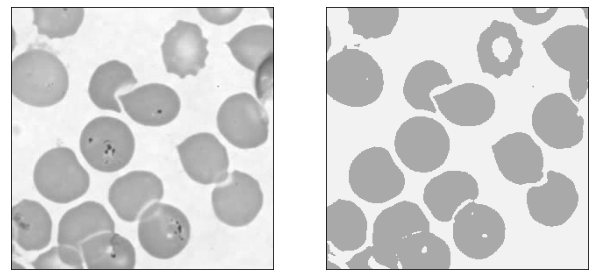

In [161]:
image = cv.imread('./images/im1.jpg', cv.IMREAD_GRAYSCALE)
ImgUtils.imshow2(
    image,
    kmeans(image, 2)
)